##### **Name : Amr Ahmed AbdEl Menem G1 Alex.** 
##### **Group :  Group 1.** 
##### **Cluster : Alexandria .** 

## Objective:
- The objective from this project is to create a <b>Logistic Regression Classifier</b> to predict the <b>Stroke Condition</b>.
- <b>Stroke</b> is a condition in which either the blood flow to the brain stops or blood flow is excessive.
- It is required to obtain <b>ROC > 0.65</b>.

### Data:
- Data is provided in csv format in a file named <b>healthcare-dataset-stroke-data.csv</b>

### Column names and data types are as follow:
- id, integer.
- gender, string.
- age, double.
- hypertension, integer.
- heart_disease, integer.
- ever_married, string.
- work_type, string.
- Residence_type, string.
- avg_glucose_level, double.
- bmi, double.
- smoking_status, string.
- stroke, integer <b>(Target Label)</b>.
If the person has stroke the stroke label value is <b>"1"</b> otherwise <b>"0"</b>.

## To perform this task follow the following guiding steps:

### Create a spark session and import the required libraries

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, StringType, StructType, StructField, IntegerType
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from itertools import chain
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StandardScaler
import numpy  as np

### Create a data schema programatically

In [3]:
data = spark.read.csv("healthcare-dataset-stroke-data.csv", header="true", inferSchema="true")

In [4]:
data.show(5,truncate=False)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|id   |gender|age |hypertension|heart_disease|ever_married|work_type    |Residence_type|avg_glucose_level|bmi |smoking_status |stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|9046 |Male  |67.0|0           |1            |Yes         |Private      |Urban         |228.69           |36.6|formerly smoked|1     |
|51676|Female|61.0|0           |0            |Yes         |Self-employed|Rural         |202.21           |N/A |never smoked   |1     |
|31112|Male  |80.0|0           |1            |Yes         |Private      |Rural         |105.92           |32.5|never smoked   |1     |
|60182|Female|49.0|0           |0            |Yes         |Private      |Urban         |171.23           |34.4|smokes         |1     |
|1665 |Female|79.0|1           |0            |Yes      

In [5]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [6]:
Schema=data.schema

### Read the data using the standard DataReader (Key,Value) pairs format
- Provide the schema and any other required options.

In [7]:
data = spark.read.csv("healthcare-dataset-stroke-data.csv", header="true", schema=Schema)

### Explore the data 
#### You have to do the following:
- Print the Schema.
- Show the first 10 rows from the data.
- Explore null values and show how many null values in each column.
- Plot a count plot for the target label and <b>notice the graph</b>.
- Perform any additional EDA you find useful.

<b>1) Printing Schema</b>

In [8]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



<b>2) First ten rows of the data</b>

In [9]:
data.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [10]:
data.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

<b> Exploring Null Values </b>

<b> The only Column with null values is the Column BMI has 201 Null Values </b>

In [11]:
null_data_count = data.agg(*[F.count(F.when(F.col(c)=="N/A", c)).alias(c) for c in data.columns])
null_data_count.show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



<b> Converting DataFrame to pandas in order to plot </b>

In [12]:
df=data.toPandas()

<b> Plot a count plot for the target label and notice the graph.</b>

<b>there is an obvious imbalance between the classes of the Stroke/NoStroke</b>

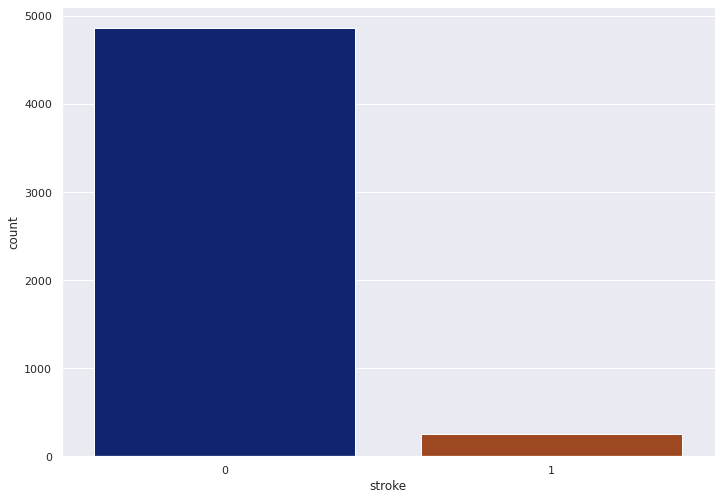

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x="stroke",data=df, palette="dark")
plt.show()

<b> From the distribution the Majority of ages in the sample lays between the 40-60 age. </b>

<b> plotting the distribution of each Numerial Column with stroke (Age,BMI,Average Glucose Level) </b>

In [14]:
import pandas as pd
#First Converting BMI to numerical Type and replacing null values with mean
df["bmi"]=df["bmi"].replace(["N/A"], 0)
df["bmi"] = pd.to_numeric(df["bmi"])
df["bmi"] = df["bmi"].replace(0,df["bmi"].mean())

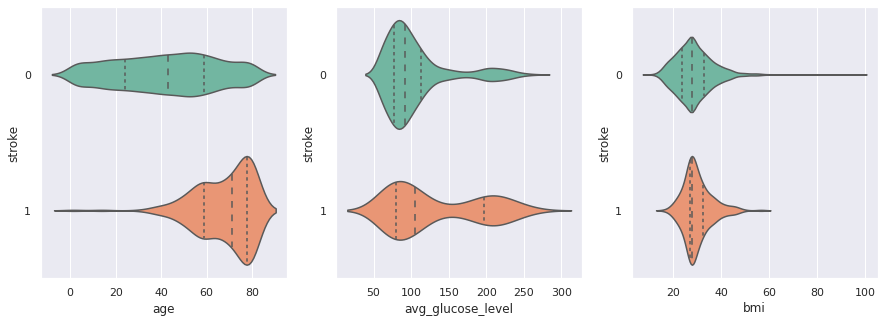

In [15]:
fig, axes = plt.subplots(1, 3,figsize=(15, 5))
sns.violinplot(ax=axes[0],data = df,x='age',y='stroke',orient="horizontal",palette='Set2',inner = "quartile")
sns.violinplot(ax=axes[1],data = df,x='avg_glucose_level',y='stroke',orient="horizontal",palette='Set2',inner = "quartile")
sns.violinplot(ax=axes[2],data = df,x='bmi',y='stroke',orient="horizontal",palette='Set2',inner = "quartile")
plt.show()

<b> Plotting the distribution of each Categorical Column with stroke</b><br>
<br>(Gender,Hyper Tension,Heart Disease, Ever Married, Work type, Residence Type, Smoking Status)<br>

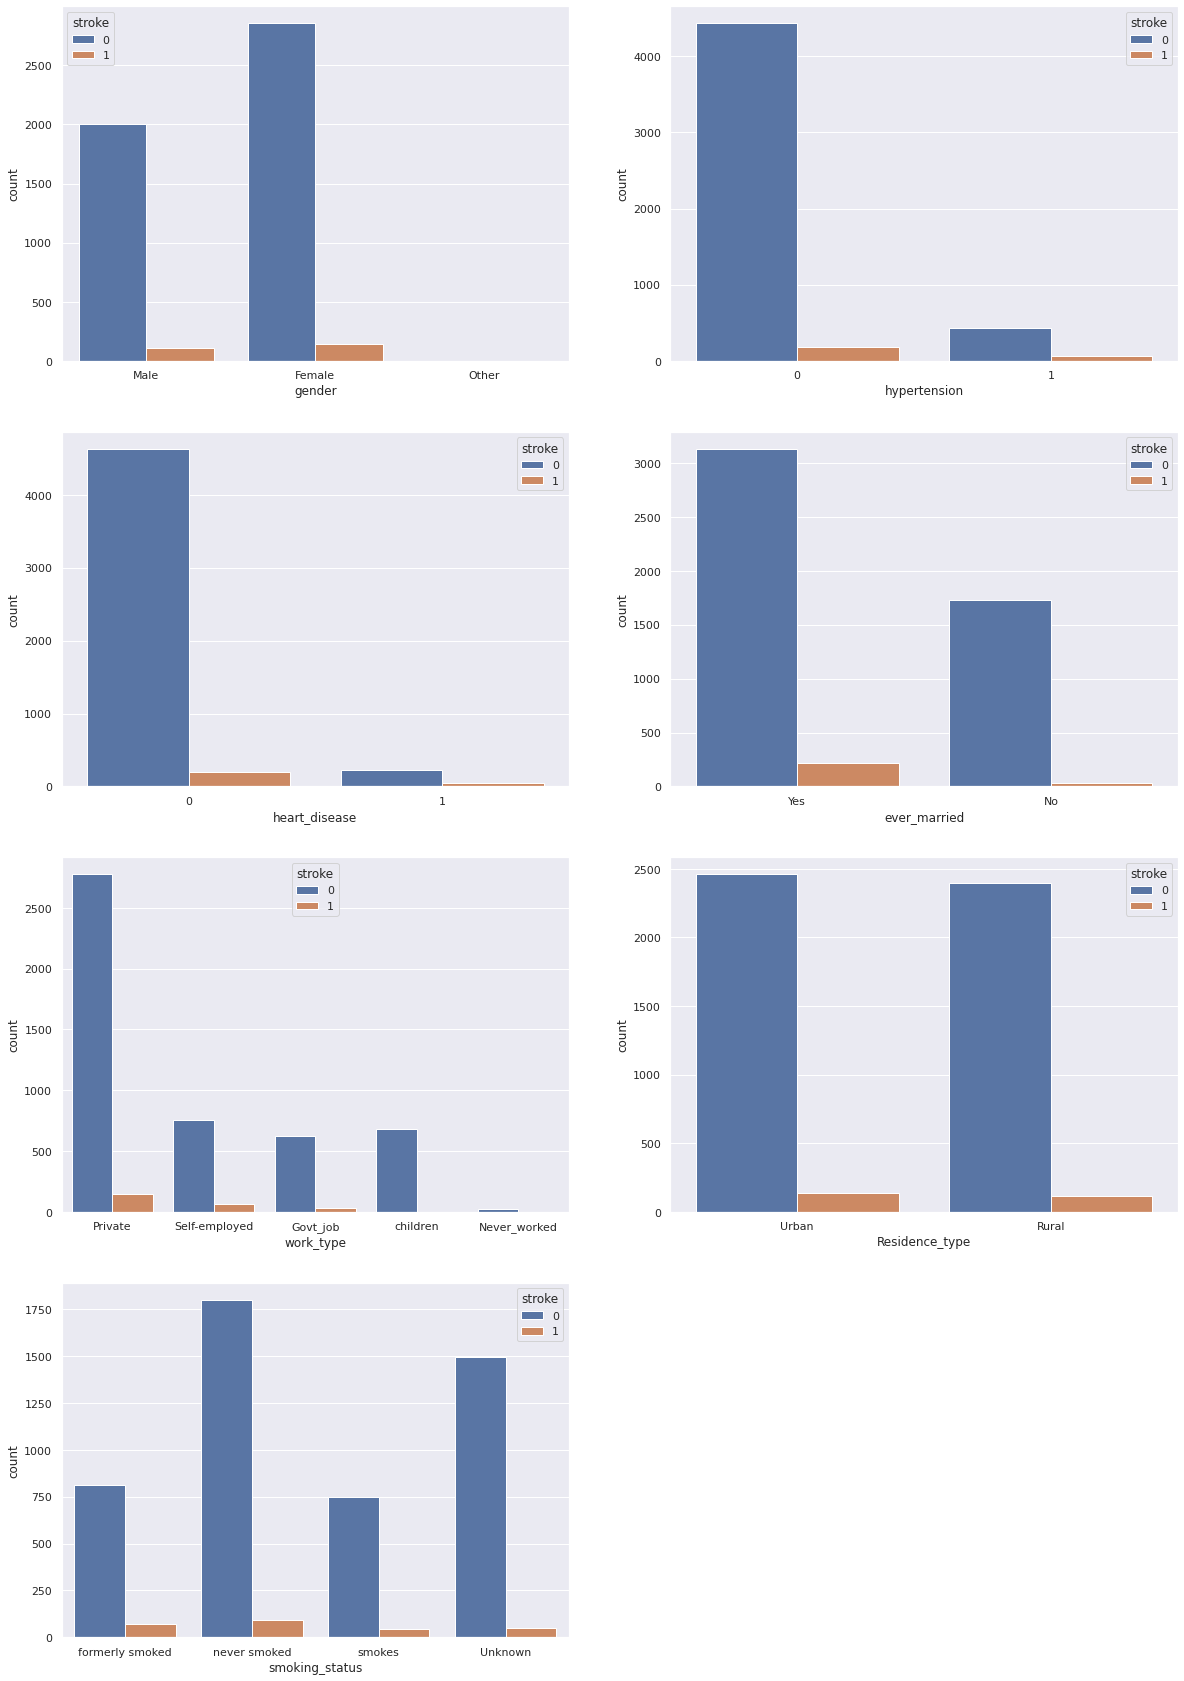

In [16]:
fig, axes = plt.subplots(4, 2,figsize=(20, 30))
fig.delaxes(axes[3,1])
sns.countplot(ax=axes[0,0],data = df,x='gender',hue="stroke")
sns.countplot(ax=axes[0,1],data = df,x='hypertension',hue="stroke")
sns.countplot(ax=axes[1,0],data = df,x='heart_disease',hue="stroke")
sns.countplot(ax=axes[1,1],data = df,x='ever_married',hue="stroke")
sns.countplot(ax=axes[2,0],data = df,x='work_type',hue="stroke")
sns.countplot(ax=axes[2,1],data = df,x='Residence_type',hue="stroke")
sns.countplot(ax=axes[3,0],data = df,x='smoking_status',hue="stroke")
plt.show()

### Get the summary statistics of the age column
- You will find the minimum age is about <b>0.08</b>.
- Remove rows for the age below <b>2 years old</b>.

In [17]:
data.describe(['age']).show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              5110|
|   mean|43.226614481409015|
| stddev| 22.61264672311348|
|    min|              0.08|
|    max|              82.0|
+-------+------------------+



<b> Removing rows where age <2 by filtering. </b>

In [18]:
data_filtered=data.filter(data.age>=2)

In [19]:
data_filtered.describe(['age']).show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              4990|
|   mean| 44.23907815631262|
| stddev|21.908077881917443|
|    min|               2.0|
|    max|              82.0|
+-------+------------------+



### Working with gender & smoking_status columns:
- Select and show the gender & smoking_status columns
- Get the distinct values for each column.

In [20]:
data_filtered.select(F.col("gender"),F.col("smoking_status")).show()

+------+---------------+
|gender| smoking_status|
+------+---------------+
|  Male|formerly smoked|
|Female|   never smoked|
|  Male|   never smoked|
|Female|         smokes|
|Female|   never smoked|
|  Male|formerly smoked|
|  Male|   never smoked|
|Female|   never smoked|
|Female|        Unknown|
|Female|        Unknown|
|Female|   never smoked|
|Female|         smokes|
|Female|         smokes|
|  Male|        Unknown|
|Female|   never smoked|
|Female|   never smoked|
|  Male|         smokes|
|  Male|         smokes|
|Female|   never smoked|
|  Male|        Unknown|
+------+---------------+
only showing top 20 rows



In [21]:
data_filtered.select('gender').distinct().show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [22]:
data_filtered.select('smoking_status').distinct().show()

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



#### Change the string values of the columns into numerical values as follow:
1. Gender column:
    * Male = 1 
    * Female = 0 
    * Other = 0 
2. Smoking Status column:
  * never smoked = 0
  * Unknown = 0.5
  * formerly smoked = 0.75
  * smokes = 1.0


In [23]:
data_filtered=data_filtered.withColumn("gender", when(col("gender")=='Male', 1)\
                                       .when(col("gender")=='Female', 0).otherwise(0))

In [24]:
data_filtered=data_filtered.withColumn("smoking_status", when(col("smoking_status")=='never smoked', 0)\
                                       .when(col("smoking_status")=='formerly smoked',0.75)\
                                       .when(col("smoking_status")=='smokes',1).otherwise(0.5))

#### Show the output DataFrame
- Select and show the gender & smoking_status columns after value changing.
- Print schema for the new dataframe.

In [25]:
data_filtered=data_filtered.withColumn("gender",col("gender").cast(StringType()))

In [26]:
data_filtered=data_filtered.withColumn("smoking_status",col("smoking_status").cast(StringType()))

In [27]:
data_filtered.select(F.col("gender"),F.col("smoking_status")).show()

+------+--------------+
|gender|smoking_status|
+------+--------------+
|     1|          0.75|
|     0|           0.0|
|     1|           0.0|
|     0|           1.0|
|     0|           0.0|
|     1|          0.75|
|     1|           0.0|
|     0|           0.0|
|     0|           0.5|
|     0|           0.5|
|     0|           0.0|
|     0|           1.0|
|     0|           1.0|
|     1|           0.5|
|     0|           0.0|
|     0|           0.0|
|     1|           1.0|
|     1|           1.0|
|     0|           0.0|
|     1|           0.5|
+------+--------------+
only showing top 20 rows



In [28]:
data_filtered.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = false)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = false)
 |-- stroke: integer (nullable = true)



### Deal with null value according to your data analysis.

In [29]:
mean=data_filtered.select(F.mean("bmi")).collect()[0][0]

In [30]:
final_data = data_filtered.withColumn("bmi", \
              when(data_filtered["bmi"] == "N/A", mean).otherwise(data_filtered["bmi"]))

In [31]:
final_data=final_data.withColumn("bmi",col("bmi").cast(DoubleType()))

In [32]:
final_data.agg(*[F.count(F.when(F.col(c)=="N/A", c)).alias(c) for c in data.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [33]:
final_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = false)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = false)
 |-- stroke: integer (nullable = true)



In [34]:
final_data=final_data.withColumn("heart_disease",col("heart_disease").cast(StringType()))

In [35]:
final_data=final_data.withColumn("hypertension",col("hypertension").cast(StringType()))

In [36]:
final_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = false)
 |-- age: double (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = false)
 |-- stroke: integer (nullable = true)



### Split the data into training and test dataframes:
- 80% training and 20% test.
- seed = 42.
- Save each dataframe as a parquet file

In [37]:
X_train, X_test = final_data.randomSplit([0.8, 0.2],seed = 42)

In [38]:
X_train.write.parquet("train.parquet") 

In [39]:
X_test.write.parquet("test.parquet") 

### Read the saved Train and Test DataFrame:
- Use the dataframes you read in the subsequent steps.

In [40]:
X_train_parquet=spark.read.parquet("train.parquet")

In [41]:
X_test_parquet=spark.read.parquet("test.parquet")

### Create the model:
- Perform feature engineering steps.
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

## Feature Engineering

<b> Extracting Categorial Columns</b>

In [42]:
categoricalCols = [field for (field, dataType) in final_data.dtypes
                   if dataType == "string"]
categoricalCols

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status']

<b> Creating Output Columns for the String Indexer and the One Hot Encoder </b>

In [43]:
indexOutputCols = [x + "_index" for x in categoricalCols]
oheOutputCols = [x + "_ohe" for x in categoricalCols]

<b> Defining String Indexer and One Hot Encoder </b>

In [44]:
stringIndexer = StringIndexer(inputCols=categoricalCols,
                             outputCols=indexOutputCols,
                             handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

<b> Extracting Numerical Columns </b>

In [45]:
numericCols = [field for (field,dataType) in final_data.dtypes
              if (((dataType=='double') |(dataType=='integer'))& (field!='stroke'))]

<b> Defining Vector Assembler Input </b>

In [46]:
assemblerInputs = oheOutputCols + numericCols
assemblerInputs

['gender_ohe',
 'hypertension_ohe',
 'heart_disease_ohe',
 'ever_married_ohe',
 'work_type_ohe',
 'Residence_type_ohe',
 'smoking_status_ohe',
 'age',
 'avg_glucose_level',
 'bmi']

<b> Defining Vector Assembler</b>

In [47]:
vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')

### Perform predictions on tests dataframe:
- Test the model using the test dataframe
- Select and show the feature column.
- Print the schema of the output dataframe.
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   

<b> Defining Logistic Regression Model and Pipeline </b>

In [48]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'stroke')
pipeline = Pipeline(stages=[stringIndexer,oheEncoder,vecAssembler,lr])


In [49]:
pipeLineModel = pipeline.fit(X_train_parquet)

In [50]:
pred=pipeLineModel.transform(X_test_parquet)

<b> Predictions </b>

In [51]:
pred.select("prediction", "stroke", "features").show(truncate=True)

+----------+------+--------------------+
|prediction|stroke|            features|
+----------+------+--------------------+
|       0.0|     0|[0.0,1.0,1.0,1.0,...|
|       0.0|     0|[1.0,1.0,1.0,0.0,...|
|       0.0|     0|[1.0,1.0,1.0,1.0,...|
|       0.0|     0|[1.0,1.0,1.0,1.0,...|
|       0.0|     0|[0.0,1.0,1.0,1.0,...|
|       0.0|     0|[1.0,1.0,1.0,1.0,...|
|       0.0|     0|(15,[2,3,5,9,12,1...|
|       0.0|     1|[1.0,1.0,1.0,1.0,...|
|       0.0|     0|(15,[0,1,2,7,10,1...|
|       0.0|     0|(15,[1,2,3,4,12,1...|
|       0.0|     0|(15,[1,2,3,6,12,1...|
|       0.0|     1|(15,[0,4,11,12,13...|
|       0.0|     0|(15,[1,2,4,9,12,1...|
|       0.0|     0|[1.0,1.0,1.0,1.0,...|
|       0.0|     0|(15,[0,2,3,4,9,12...|
|       0.0|     0|[1.0,1.0,1.0,1.0,...|
|       0.0|     0|[1.0,1.0,1.0,0.0,...|
|       0.0|     0|(15,[2,3,4,8,12,1...|
|       0.0|     0|[0.0,1.0,1.0,1.0,...|
|       0.0|     0|[1.0,1.0,1.0,0.0,...|
+----------+------+--------------------+
only showing top

### Evaluate the model performance
- Use <b>BinaryClassificationEvaluator</b>. This will calculate the <b>ROC</b>.
- Set the parameters as follow:
    - <b>rawPredictionCol='prediction'</b> and <b>labelCol='stroke'</b>

In [52]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [53]:
evaluatorROC.evaluate(pred)

0.5

### Improve Model Performance
- You may noticed that <b>the target label is imbalanced</b>.
- LogisticRegression classifier has a special parameter <b>weightCol</b> to deal with imbalanced class.
- In order to use this parameter you must have a <b>weightCol</b> in your training dataframe.
- In order to create this column you will need to define a <b>UDF</b> and apply it to the target label column.
- Create a LogisticRegression classifier with <b>weightCol</b> parameter.
- Build and train a pipeline model with the new LogisticRegression.
- Perform the prediction on the test dataframe. 
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   
- Evaluate the model performance exactly as in the previous step.
### YOU SHOULD OBTAIN  ROC > 0.65
<BR>
<b><font color='red'>Note: feel free to deal with the imbalanced cluster with the above method or another. However, you can only use methods applied on SPARK DATAFRAME</font></b>

## Dealing With Imbalanced lcasses

<b>Getting count and ratio of each class</b>

In [54]:
major_df = X_train_parquet.filter(col("stroke") == 0)
minor_df = X_train_parquet.filter(col("stroke") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 18


<b> In the train dataset the 0 class (No Stroke) is 18 times the 1 class (Stroke)

<b> Using Class weights and adding them to weight column parameter for the logistic regression model to mitigate the issue of the imbalance.

<b> Calculating the weights </b>

In [55]:
y_collect = X_train_parquet.select("stroke").groupBy("stroke").count().collect()
unique_y = [x["stroke"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark)

{1: 9.992574257425742, 0: 0.5263363754889179}


<b> Creating The WeightCol </b>

In [56]:
mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])

X_train_parquet = X_train_parquet.withColumn("weight", mapping_expr.getItem(F.col("stroke")))

## Standard Scaling

<b> in addition to dealing with the imbalanced dataset ,logistic regression is very sensitive to the range of the data points</b>
<br><b>so we will redefine the pipleline and add a standard scaler step to deal with numerical columns</b>

In [57]:
##Categorical
categoricalCols = [field for (field, dataType) in final_data.dtypes
                   if dataType == "string"]
indexOutputCols = [x + "_index" for x in categoricalCols]
oheOutputCols = [x + "_ohe" for x in categoricalCols]
stringIndexer = StringIndexer(inputCols=categoricalCols,
                             outputCols=indexOutputCols,
                             handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)
#Numerical
numericCols = [field for (field,dataType) in final_data.dtypes
              if (((dataType=='double') |(dataType=='integer'))& (field!='stroke'))]
assembler_1 = VectorAssembler(inputCols=numericCols, outputCol="x_vec")
scaler = StandardScaler(inputCol="x_vec", outputCol="x_scaled")

#Assembler
assemblerInputs = ["x_scaled"] + oheOutputCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')

<b> Applying to the Model </b>

In [58]:
# Notice WeightCol
lr = LogisticRegression(featuresCol = 'features', labelCol = 'stroke',weightCol='weight')
new_pipeline = Pipeline(stages=[stringIndexer,oheEncoder,assembler_1,scaler,vecAssembler,lr])


In [59]:
new_pipeLineModel = new_pipeline.fit(X_train_parquet)

<b> Prediction </b>

In [60]:
new_pred=new_pipeLineModel.transform(X_train_parquet)

<b> Evaluation </b>

In [61]:
evaluation=evaluatorROC.evaluate(new_pred)
print(f"The Evaluation of the Model Prediction is : {evaluation}")

The Evaluation of the Model Prediction is : 0.7788161410665185
